In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re #clean text efficiently
import seaborn as sns
import string
import nltk
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score,accuracy_score,roc_curve,auc
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore",category = FutureWarning)
warnings.filterwarnings("ignore",category= DeprecationWarning)

In [7]:
#import the dataset
data = pd.read_csv("sentiment.tsv",sep = "\t")
data.columns = ['label','body_text'] #create labels for columns
data.head()

,label,body_text
0,pos,having a vodka tonic and looking forward to go...
1,pos,@ddlovatofans1neg1 Could you follow me please....
2,pos,@jordanknight for once.................. PLEAS...
3,neg,Had a dream about a walk in fast food resturau...
4,pos,@TroyBrownBBNews Yes... For a &quot;friend&quot;


In [9]:
#pre Processing the data. make string to binary of dependent variable
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
data['label'] = label.fit_transform(data['label']) #pos=1, neg=0
data.head()

,label,body_text
0,1,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....
2,1,@jordanknight for once.................. PLEAS...
3,0,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;


In [10]:
#clean the data
def remove_pattern(input_text,pattern): #remove some pattern
    r = re.findall(pattern,input_text)
    for i in r:
        input_text = re.sub(i,'',input_text) #replace the pattern with null char
    return input_text

In [11]:
#remove twitter handles(@user)
data['processed_tweet'] = np.vectorize(remove_pattern)(data['body_text'],"@[\w]*") #"@[\w]*" remove @user from text

In [12]:
data.head()

,label,body_text,processed_tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes... For a &quot;friend&quot;


In [13]:
#Remove special characters, numbers, punctuations
#can be done as in a loop of col in dataset data['processed_tweet'] = re.sub('[^a-zA-Z]',' ',data['Processed_tweet'][i])
data['processed_tweet'] = data['processed_tweet'].str.replace('[^a-zA-Z#]',' ')
data.head()

,label,body_text,processed_tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes For a quot friend quot


In [14]:
#Tokenize the tweets
tokenized_tweet = data['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet.head() #make a list of words in a row

0    [having, a, vodka, tonic, and, looking, forwar...
1    [Could, you, follow, me, please, I, would, rea...
2    [for, once, PLEASE, TELL, US, WHY, u, were, th...
3    [Had, a, dream, about, a, walk, in, fast, food...
4                    [Yes, For, a, quot, friend, quot]
Name: processed_tweet, dtype: object

In [15]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [have, a, vodka, tonic, and, look, forward, to...
1    [could, you, follow, me, pleas, I, would, real...
2    [for, onc, pleas, tell, US, whi, u, were, thin...
3    [had, a, dream, about, a, walk, in, fast, food...
4                     [ye, for, a, quot, friend, quot]
Name: processed_tweet, dtype: object

In [16]:
#Joining the tokenized word in the same data
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
data['processed_tweet'] = tokenized_tweet
data.head()

,label,body_text,processed_tweet
0,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...
1,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...
2,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...
3,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,ye for a quot friend quot


In [17]:
#Adding other column for length of the tweet and punctuation
def count_punct(text):#count the percentage of punctuation in one tweet
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")),3)*100 

In [19]:
data['text_len'] = data['body_text'].apply(lambda x:len(x) - x.count(' '))
data['punct%'] = data['body_text'].apply(lambda x:count_punct(x))
data.head()

,label,body_text,processed_tweet,text_len,punct%
0,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...,92,1.1
1,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...,66,4.5
2,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...,81,27.2
3,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...,96,1.0
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,ye for a quot friend quot,44,18.2


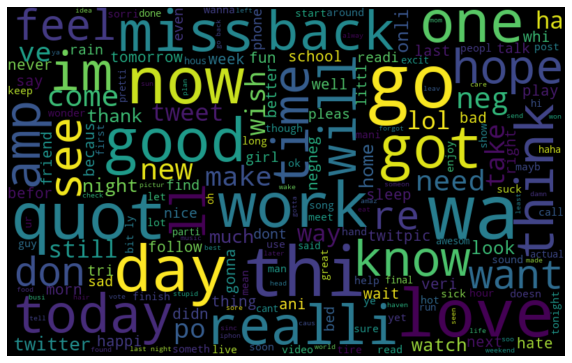

In [22]:
#Generating word cloud for data
corpus = ''.join([text for text in data['processed_tweet']]) #join all rows
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(corpus)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud,interpolation = 'bilinear') #interpolation makes the pic clear
plt.axis('off')
plt.show()

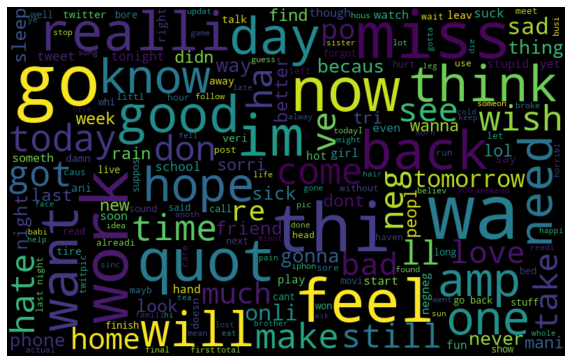

In [23]:
#wordCloud for nehative Words
negative_words = ''.join(text for text in data['processed_tweet'][data['label']==0])#texts for neg review
wordcloud = WordCloud(width=800, height = 500, random_state=21,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
#Feature selection and Engineering
#1) Count Vectorizer
#2) Tfidf Vectoriser
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(stop_words = 'english')
bow = bow_vectorizer.fit_transform(data['processed_tweet'])
X_count_feat = pd.concat([data['text_len'],data['punct%'],pd.DataFrame(bow.toarray())],axis = 1)
X_count_feat.head()

,text_len,punct%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,4.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,81,27.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,18.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#term frequency - how many times a word appears counts the probability on 0-1
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['processed_tweet'])
X_tfidf_feat = pd.concat([data['text_len'],data['punct%'],pd.DataFrame(tfidf.toarray())],axis = 1)
X_tfidf_feat.head()

,text_len,punct%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,81,27.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,44,18.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Testing all classification algorithms
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [28]:
model = []
model.append(('LR',LogisticRegression()))
model.append(('RF',RandomForestClassifier()))
model.append(('GB',GradientBoostingClassifier()))
model.append(('DT',DecisionTreeClassifier()))
model.append(('NB',GaussianNB()))
model.append(('KNN',KNeighborsClassifier()))
model.append(('SVC',SVC()))

In [29]:
#10 fold crossvalidation for all the algorithms with X_count_feat data
for mod,clf in model:
    scores = cross_val_score(clf,X_count_feat,data['label'],scoring = 'accuracy',cv = 10)
    print("Model is %s and Score %f"%(mod,scores.mean()))

C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Model is LR and Score 0.673944


C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Model is RF and Score 0.629958
Model is GB and Score 0.640473
Model is DT and Score 0.596932
Model is NB and Score 0.596997
Model is KNN and Score 0.501987


C:\Users\88016\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

Model is SVC and Score 0.488500


In [30]:
#Model is LR and Score 0.673944
#Model is RF and Score 0.629958
#Model is GB and Score 0.640473
#Model is DT and Score 0.596932
#Model is NB and Score 0.596997
#Model is KNN and Score 0.501987
#Model is SVC and Score 0.488500

In [31]:
#10 fold crossvalidation for all the algorithms with X_tfidf_feat data
for mod,clf in model:
    scores = cross_val_score(clf,X_tfidf_feat,data['label'],scoring = 'accuracy',cv = 10)
    print("Model is %s and Score %f"%(mod,scores.mean()))

C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Model is LR and Score 0.679419


C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Model is RF and Score 0.638530
Model is GB and Score 0.630963
Model is DT and Score 0.589009
Model is NB and Score 0.600967
Model is KNN and Score 0.488995


C:\Users\88016\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\88016\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

Model is SVC and Score 0.493005


In [32]:
#Model is LR and Score 0.679419
#Model is RF and Score 0.638530
#Model is GB and Score 0.630963
#Model is DT and Score 0.589009
#Model is NB and Score 0.600967
#Model is KNN and Score 0.488995
#Model is SVC and Score 0.493005

In [35]:
#1) Parameter tuning Linear Regression Count Vectorizer
param_grid = {'C':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv = 10)
grid.fit(X_count_feat,data['label'])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [36]:
grid.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
#using best Estimator in the model
Logistic_model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
scores = cross_val_score(Logistic_model,X_count_feat,data['label'],scoring='accuracy',cv=10)
print("Model is %s and Score %f"%("LR",scores.mean()))
#Model is LR and Score 0.689934

Model is LR and Score 0.689934


In [38]:
#2) Parameter tuning Linear Regression TfiD
param_grid = {'C':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv = 10)
grid.fit(X_tfidf_feat,data['label'])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [40]:
grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
scores = cross_val_score(Logistic_model,X_tfidf_feat,data['label'],scoring='accuracy',cv=10)
print("Model is %s and Score %f"%("LR",scores.mean()))
#Model is LR and Score 0.660486

Model is LR and Score 0.660486


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_count_feat, data['label'], test_size=0.33, random_state=42)

In [43]:
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_pred = model.predict(X_test)

In [45]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [46]:
accuracy_score(y_pred,y_test)

0.6803030303030303

In [47]:
confusion_matrix(y_test,y_pred)

array([[218,  95],
       [116, 231]], dtype=int64)

In [48]:
#accuracy = 68% 